In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.vgg import vgg16

from torchvision.transforms import transforms
import numpy as np
import cv2
from collections import OrderedDict
from functools import partial
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
class Vgg16(nn.Module):
    
    def __init__(self):
        super(Vgg16, self).__init__()
        
        pretrain_model = vgg16(pretrained=True)
        model = self._revise_pool(pretrain_model)
        self.features = model.features
        self.classifier = model.classifier
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()
        
    def _revise_pool(self, model):
         for layer_idx, layer in enumerate(model.features):
            if isinstance(layer, nn.MaxPool2d):
                model.features[layer_idx] = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
         return model
    
        
    def forward(self, x):
        for layer_idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
            else:
                x = layer(x)
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output

In [3]:
class Vgg16Deconv(nn.Module):
    
    def __init__(self):
        super(Vgg16Deconv, self).__init__()

        self.features = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),

            # deconv2
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding=1),
            
            # deconv3
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding=1),
            
            # deconv4
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            
            # deconv5
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding=1)    
        )

        self.conv2deconv_indices = {
                0:30, 2:28, 5:25, 7:23,
                10:20, 12:18, 14:16, 17:13,
                19:11, 21:9, 24:6, 26:4, 28:2
                }

        self.unpool2pool_indices = {
                26:4, 21:9, 14:16, 7:23, 0:30
                }

        self.init_weight()
        
    def init_weight(self):
        vgg16_pretrained = vgg16(pretrained=True)
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                
    def forward(self, x, layer, activation_idx, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        else:
            raise ValueError('layer is not a conv feature map')

        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                x = self.features[idx]\
                (x, pool_locs[self.unpool2pool_indices[idx]])
            else:
                x = self.features[idx](x)
        return x

In [4]:
import os
import requests
import json

"""
this file is utils lib
"""


def decode_predictions(preds, top=5):
    """Decode the prediction of an ImageNet model

    # Arguments
        preds: torch tensor encoding a batch of predictions.
        top: Integer, how many top-guesses to return

    # Return
        A list of lists of top class prediction tuples
        One list of turples per sample in batch input.

    """


    class_index_path = 'https://s3.amazonaws.com\
/deep-learning-models/image-models/imagenet_class_index.json'

    class_index_dict = None

    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predciton'
        '(i.e. a 2D array of shape (samples, 1000)).'
        'Found array with shape: ' + str(preds.shape)
        )

    if not os.path.exists('./data/imagenet_class_index.json'):
        r = requests.get(class_index_path).content
        with open('./data/imagenet_class_index.json', 'w+') as f:
            f.write(r.content)
    with open('./data/imagenet_class_index.json') as f:
        class_index_dict = json.load(f)

    results = []
    for pred in preds:
        top_value, top_indices = torch.topk(pred, top)
        result = [tuple(class_index_dict[str(i.item())]) + (pred[i].item(),) \
                for i in top_indices]
        result = [tuple(class_index_dict[str(i.item())]) + (j.item(),) \
        for (i, j) in zip(top_indices, top_value)]
        results.append(result)

    return results

In [5]:
def load_images(img_path):
    # imread from img_path
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # pytorch must normalize the pic by 
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    #img_s = img.numpy()
    #img_s = np.transpose(img_s, (1, 2, 0))
    #cv2.imshow("test img", img_s)
    #cv2.waitKey()
    return img

In [6]:
def store(model):
    """
    make hook for feature map
    """
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.pool_locs[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [7]:
def vis_layer(layer, vgg16_conv, vgg16_deconv):
    """
    visualing the layer deconv result
    """
    print(vgg16_conv.feature_maps[layer].shape)
    num_feat = vgg16_conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = vgg16_conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
#     if mark == 0:
#         new_feat_map[:, 1:, :, :] = 0
#     else:
#         new_feat_map[:, :mark, :, :] = 0
#         if mark != vgg16_conv.feature_maps[layer].shape[1] - 1:
#             new_feat_map[:, mark + 1:, :, :] = 0

    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )
    new_feat_map = torch.zeros(vgg16_conv.feature_maps[layer].shape)
    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    print(max_activation)
    
    deconv_output = vgg16_deconv(new_feat_map, layer, mark, vgg16_conv.pool_locs)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

Predicted: [('n02123394', 'Persian_cat', 11.783759117126465), ('n02328150', 'Angora', 10.46151351928711), ('n02120079', 'Arctic_fox', 10.057705879211426)]
torch.Size([1, 256, 56, 56])
tensor(84.4530, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 28, 28])
tensor(76.9078, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 28, 28])
tensor(54.1728, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 28, 28])
tensor(38.9018, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 14, 14])
tensor(42.2611, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 14, 14])
tensor(27.9253, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 14, 14])
tensor(34.3273, grad_fn=<MaxBackward1>)


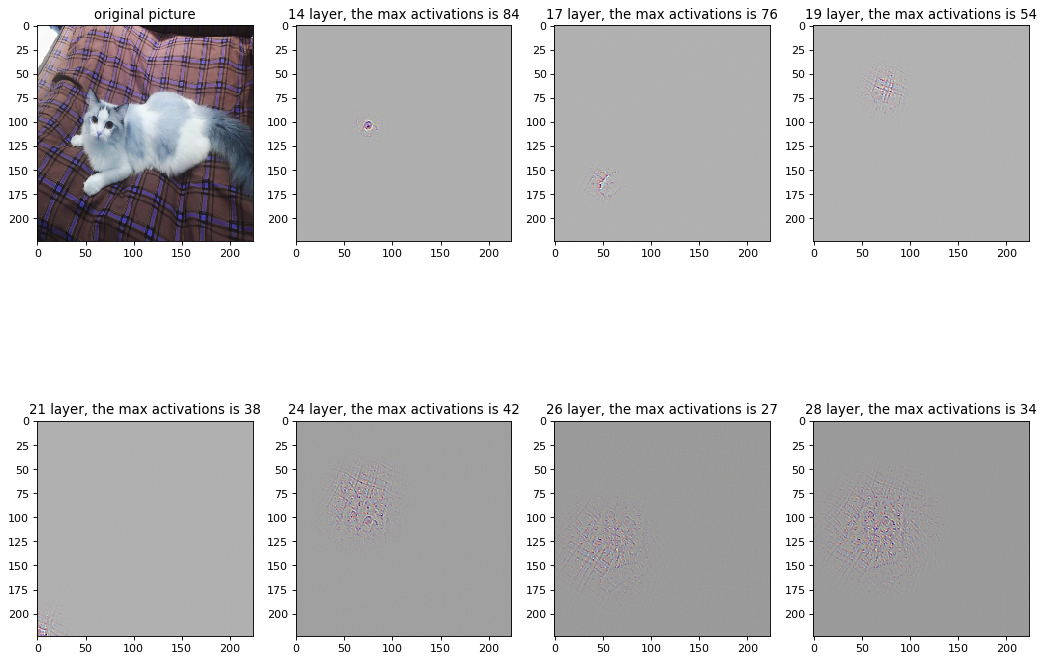

In [9]:
img_path = './data/test.jpg'

    # forward processing
img = load_images(img_path)
vgg16_conv = Vgg16()
vgg16_conv.eval()
store(vgg16_conv)
conv_output = vgg16_conv(img)
pool_locs = vgg16_conv.pool_locs
print('Predicted:', decode_predictions(conv_output, top=3)[0])



# backward processing
vgg16_deconv = Vgg16Deconv()
vgg16_deconv.eval()
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.subplot(2, 4, 1)
plt.title('original picture')
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
plt.imshow(img)    
for idx, layer in enumerate([14, 17, 19, 21, 24, 26, 28]):
# for idx, layer in enumerate(vgg16_conv.conv_layer_indices):        
    plt.subplot(2, 4, idx+2)
    img, activation = vis_layer(layer, vgg16_conv, vgg16_deconv)
    plt.title(f'{layer} layer, the max activations is {activation}')
    # img = img[112:,112:,:]
    plt.imshow(img)